<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Making-predictions-with-logistic-regression" data-toc-modified-id="Making-predictions-with-logistic-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Making predictions with logistic regression</a></span><ul class="toc-item"><li><span><a href="#Creating-a-query" data-toc-modified-id="Creating-a-query-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating a query</a></span></li><li><span><a href="#Reading-the-data-into-a-Pandas-dataframe" data-toc-modified-id="Reading-the-data-into-a-Pandas-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Reading the data into a Pandas dataframe</a></span></li><li><span><a href="#Analyze-extracted-features" data-toc-modified-id="Analyze-extracted-features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Analyze extracted features</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-numerical-columns" data-toc-modified-id="Preprocessing-numerical-columns-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Preprocessing numerical columns</a></span></li><li><span><a href="#Preprocessing-categorical-columns" data-toc-modified-id="Preprocessing-categorical-columns-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Preprocessing categorical columns</a></span></li></ul></li></ul></li></ul></div>

# Making predictions with logistic regression

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass    # get the password without it being visible
password = getpass.getpass()

········


In [2]:

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila' 
engine = create_engine(connection_string)

## Creating a query

I created a query which joins tables film,language,rental,payment,category and inventory. The latest is used kind of bridge table. I am interested with the columns name from category table,title, rental_rate, rating and length from rental table. Moreover, by using other joined tables, I created four other columns that could be relevant, first of them is named as noofrenting which means how many times that film is rented so far; second of them is called as last_rental which collects the last rental_date by title; third gives the average rental cost and the last one is average rental cost. 

In [3]:
query = """ 
select ca.name as category,title,rental_duration,rating, length,count(distinct rental_id) as noofrenting, 
max(rental_date) as last_rental,
round(avg(timestampdiff(hour,rental_date,return_date))) as avg_rental_hour, 
round(avg(p.amount),2) as avg_rent_cost
from film 
join inventory using(film_id)
join rental using(inventory_id)
join payment p using(rental_id)
join film_category  using(film_id)
join category ca using(category_id)
group by title, category, rating,length, rental_duration;
"""

## Reading the data into a Pandas dataframe

In this section, the above query is read by using Pandas to obtain a dataframe, then try to understand its nature.

In [4]:
data = pd.read_sql_query(query,engine)

In [5]:
data.head()

,category,title,rental_duration,rating,length,noofrenting,last_rental,avg_rental_hour,avg_rent_cost
0,Documentary,ACADEMY DINOSAUR,6,PG,86,23,2005-08-23 01:01:01,119.0,1.60
1,Horror,ACE GOLDFINGER,3,G,48,7,2006-02-14 15:16:03,135.0,7.56
2,Documentary,ADAPTATION HOLES,7,NC-17,50,12,2005-08-23 13:54:39,83.0,3.16
3,Horror,AFFAIR PREJUDICE,5,G,117,23,2006-02-14 15:16:03,114.0,3.99
4,Family,AFRICAN EGG,6,G,130,12,2006-02-14 15:16:03,170.0,4.32


In [6]:
data.isna().sum()   # We don't have any nulls. 

category           0
title              0
rental_duration    0
rating             0
length             0
noofrenting        0
last_rental        0
avg_rental_hour    0
avg_rent_cost      0
dtype: int64

In [7]:
data.shape

(958, 9)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   category         958 non-null    object        
 1   title            958 non-null    object        
 2   rental_duration  958 non-null    int64         
 3   rating           958 non-null    object        
 4   length           958 non-null    int64         
 5   noofrenting      958 non-null    int64         
 6   last_rental      958 non-null    datetime64[ns]
 7   avg_rental_hour  958 non-null    float64       
 8   avg_rent_cost    958 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 67.5+ KB


## Analyze extracted features

### Preprocessing numerical columns

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
corr_matrix = data.corr()

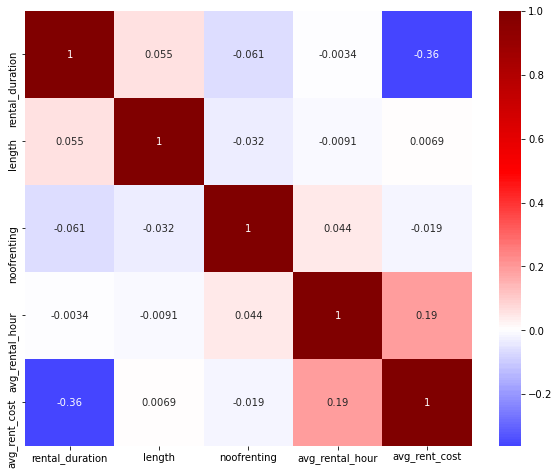

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix,
           cmap='seismic',
           center=0,
           annot=True,
           );

In [12]:
X_num = data.select_dtypes(include = np.number)

**Before any preprocessing**

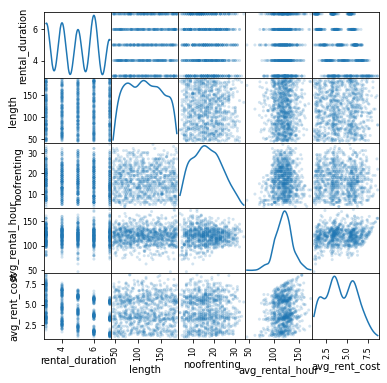

In [20]:
from pandas.plotting import scatter_matrix
output = scatter_matrix(X_num,alpha=0.2,figsize=(6,6),diagonal='kde');
# not that bad, some of them seems normally distributed

**Normalizer() is applied**

In [21]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_num)
X_normalized= transformer.transform(X_num)

In [22]:
X_normalized

array([[0.04033796, 0.57817742, 0.15462885, 0.8000362 , 0.01075679],
       [0.02087963, 0.33407401, 0.04871913, 0.93958317, 0.05261666],
       [0.07147329, 0.51052351, 0.12252564, 0.84746902, 0.03226509],
       ...,
       [0.03390926, 0.5934121 , 0.05086389, 0.80251922, 0.00938156],
       [0.02976252, 0.60120288, 0.10119256, 0.791683  , 0.02583387],
       [0.02417545, 0.40292424, 0.24981303, 0.87837484, 0.0558453 ]])

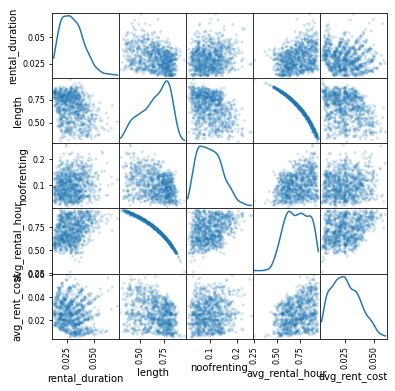

In [24]:
X_norm=pd.DataFrame(X_normalized, columns = X_num.columns)
scatter_matrix(X_norm,alpha=0.2,figsize=(6,6),diagonal='kde');

**Here, StandardScaler() is applied. Then I decided to go with the result of Normalizer(). Because with StandardSacaler, some of them is better, for example, noofrenting and avg_rental_hour, however others are really worse than Normalized() versions.** 

In [25]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_num)
X_standardised= transformer.transform(X_num)

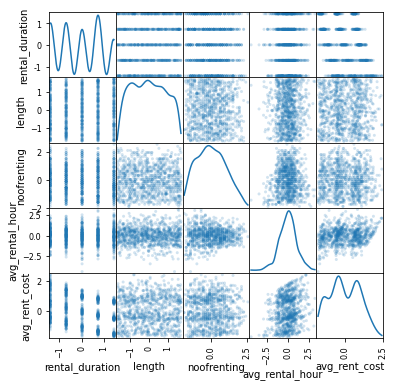

In [26]:
X_std=pd.DataFrame(X_standardised, columns= X_num.columns)
scatter_matrix(X_std,alpha=0.2,figsize=(6,6),diagonal='kde');

### Preprocessing categorical columns

In [ ]:
X_cat = data.select_dtypes(include = np.object)

In [ ]:
X_cat.head()

In [ ]:
X_cat = X_cat.drop(['title'],axis=1)   # title seems as a categorical column but actually it is irrelevant.

In [ ]:
X_cat = pd.get_dummies(X_cat,
               drop_first=True,
               columns=X_cat.columns)
X_cat

In [1]:
query_last_month = """
select title,
sum(case when rental_date like '2006-02%' then 1 else 0 end) as last_month_activity from film 
join inventory using(film_id)
join rental using(inventory_id)
group by title;
"""

In [2]:
data = pd.read_sql_query(query_last_month,engine)

NameError: name 'pd' is not defined